In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 34 Lecture 2 Assignment

In this assignment, we will learn about gradient boosting. We will use a dataset of house information in Ames, Iowa, predicting sale price.

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

from category_encoders import LeaveOneOutEncoder

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
house = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/houseprices.csv"
).drop(columns="id")
print(house.shape)
house.head()

(1460, 80)


,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<IPython.core.display.Javascript object>

Check for nulls. Remove any columns with more than 100 nulls, then drop any remaining rows with nulls after that.

In [4]:
na_counts = house.isna().sum()
hi_na_counts = na_counts[na_counts > 100]
hi_na_count_cols = hi_na_counts.index

house = house.drop(columns=hi_na_count_cols)
house = house.dropna()

<IPython.core.display.Javascript object>

Take a look at your outcome variable. It is highly skewed, and has a few very rare large outliers.

Let's try log transforming the y variable.

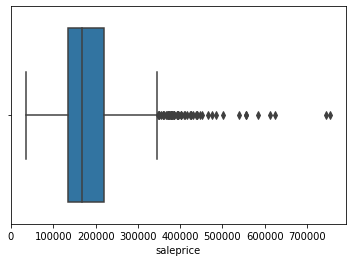

<IPython.core.display.Javascript object>

In [5]:
sns.boxplot("saleprice", data=house)
plt.show()

In [6]:
house["saleprice"] = np.log(house["saleprice"])

<IPython.core.display.Javascript object>

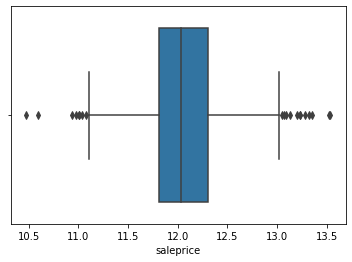

<IPython.core.display.Javascript object>

In [7]:
sns.boxplot("saleprice", data=house)
plt.show()

We know that there are some rare large values. We can make sure that the training and test sets have about the same distribution by stratifying the train-test split.

Split your training and test sets, with a test size of 0.2. Use the given helper function to stratify the continuous outcome. Remember that the outcome variable is now the **log of sale price**.

In [8]:
def binned(y, num_bins=10):
    # Creates an object to put in the stratify keyword in train_test_split
    # Specify number of bins to separate your y variable
    ymin, ymax = y.min(), y.max()
    bins = np.linspace(ymin, ymax, num_bins + 1)[:-1]
    y_binned = np.digitize(y, bins)
    return y_binned

<IPython.core.display.Javascript object>

In [9]:
X = house.drop(columns="saleprice")
y = house["saleprice"]

<IPython.core.display.Javascript object>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=binned(y)
)

<IPython.core.display.Javascript object>

In [11]:
X_train.select_dtypes("number").columns

Index(['mssubclass', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt',
       'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf',
       'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
       'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt',
       'garagecars', 'garagearea', 'wooddecksf', 'openporchsf',
       'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval',
       'mosold', 'yrsold'],
      dtype='object')

<IPython.core.display.Javascript object>

In [12]:
# fmt: off
cat_cols = [
    "mssubclass", "street", "lotshape", "landcontour", "utilities",
    "lotconfig", "landslope", "neighborhood", "condition1", "condition2",
    "bldgtype", "housestyle", "roofstyle", "roofmatl", "exterior1st",
    "exterior2nd", "masvnrtype", "exterqual", "extercond", "foundation",
    "bsmtqual", "bsmtcond", "bsmtexposure", "bsmtfintype1", "bsmtfintype2",
    "heating", "heatingqc", "centralair", "electrical", "kitchenqual",
    "functional", "garagetype", "garagefinish", "garagequal", "garagecond",
    "paveddrive", "saletype", "salecondition"
]

num_cols = ["lotarea", "overallqual", "overallcond", "yearbuilt",
            "yearremodadd", "masvnrarea", "bsmtfinsf1", "bsmtfinsf2", "bsmtunfsf",
            "totalbsmtsf", "firstflrsf", "secondflrsf", "lowqualfinsf", "grlivarea",
            "bsmtfullbath", "bsmthalfbath", "fullbath", "halfbath", "bedroomabvgr",
            "kitchenabvgr", "totrmsabvgrd", "fireplaces", "garageyrblt",
            "garagecars", "garagearea", "wooddecksf", "openporchsf",
            "enclosedporch", "threessnporch", "screenporch", "poolarea", "miscval",
            "mosold", "yrsold"]
# fmt: on

<IPython.core.display.Javascript object>

Create a Gradient Boosting Regressor model. Measure the MAE (Mean Absolute Error) for the training and testing sets.

In [13]:
preprocessing = ColumnTransformer(
    [
        ("leave_one_out_encode", LeaveOneOutEncoder(), cat_cols),
        ("scale", StandardScaler(), num_cols),
    ]
)

<IPython.core.display.Javascript object>

In [14]:
pipeline = Pipeline(
    [("preprocessing", preprocessing), ("gbtree", GradientBoostingRegressor())]
)

<IPython.core.display.Javascript object>

In [15]:
pipeline.fit(X_train, y_train)

pipeline.score(X_train, y_train)

-0.003064517907918285

<IPython.core.display.Javascript object>

In [16]:
pipeline.score(X_test, y_test)

-0.004384041167653452

<IPython.core.display.Javascript object>

In [17]:
# MAE in dollars
y_pred = pipeline.predict(X_test)

resid = np.exp(y_pred) - np.exp(y_test)
np.mean(np.abs(resid))

54962.51455238165

<IPython.core.display.Javascript object>

In [18]:
# MAE in dollars if we just guessed the average price
# This is a better prediction than the untuned model
# thats why theres a negative R^2
y_pred = np.mean(y_train)

resid = np.exp(y_pred) - np.exp(y_test)
np.mean(np.abs(resid))

54865.41259637141

<IPython.core.display.Javascript object>

Create a grid search. Try varying subsample, learning rate, and max features. Use MAE as your scoring metric.

In [19]:
grid = {
    "gbtree__learning_rate": [0.01, 0.1, 0.5],
    "gbtree__n_estimators": [50, 100, 150],
    "gbtree__max_features": [0.5, 0.7, 0.9],
    "gbtree__subsample": [0.7, 0.9],
    "gbtree__max_depth": [3, 5],
}

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

pipeline_cv.best_params_

Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   45.7s finished


{'gbtree__learning_rate': 0.5,
 'gbtree__max_depth': 3,
 'gbtree__max_features': 0.5,
 'gbtree__n_estimators': 100,
 'gbtree__subsample': 0.7}

<IPython.core.display.Javascript object>

In [20]:
pipeline_cv.score(X_train, y_train)

-0.0181970805222349

<IPython.core.display.Javascript object>

In [21]:
pipeline_cv.score(X_test, y_test)

-0.010824020079087227

<IPython.core.display.Javascript object>

Create residual plots of the training and test sets and interpret your results.

In [22]:
# MAE in dollars
# Compare to MAE of predicting the average: 54865
y_pred = pipeline_cv.predict(X_test)

resid = np.exp(y_pred) - np.exp(y_test)
np.mean(np.abs(resid))

55192.45215544249

<IPython.core.display.Javascript object>

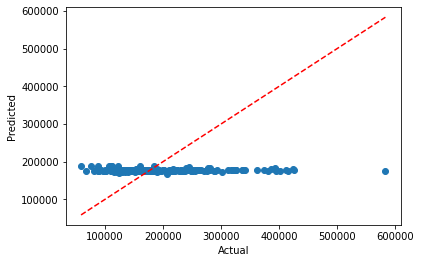

<IPython.core.display.Javascript object>

In [23]:
y_pred = pipeline_cv.predict(X_test)

# Convert to dollars
y_true = np.exp(y_test)
y_pred = np.exp(y_pred)

mn = y_true.min()
mx = y_true.max()

plt.scatter(y_true, y_pred)
plt.plot([mn, mx], [mn, mx], "--", c="red")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

Really poor model, more time should be spent with the features.